In [7]:
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import missingno as msno

In [8]:
# Load data using Dask
file_path = "yellow_tripdata_2016-03.csv"
ddf = dd.read_csv(file_path)
ddf.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-03-01 00:00:00,2016-03-01 00:07:55,1,2.50,-73.976746,40.765152,1,N,-74.004265,40.746128,1,9.0,0.5,0.5,2.05,0.00,0.3,12.35
1,1,2016-03-01 00:00:00,2016-03-01 00:11:06,1,2.90,-73.983482,40.767925,1,N,-74.005943,40.733166,1,11.0,0.5,0.5,3.05,0.00,0.3,15.35
2,2,2016-03-01 00:00:00,2016-03-01 00:31:06,2,19.98,-73.782021,40.644810,1,N,-73.974541,40.675770,1,54.5,0.5,0.5,8.00,0.00,0.3,63.80
3,2,2016-03-01 00:00:00,2016-03-01 00:00:00,3,10.78,-73.863419,40.769814,1,N,-73.969650,40.757767,1,31.5,0.0,0.5,3.78,5.54,0.3,41.62
4,2,2016-03-01 00:00:00,2016-03-01 00:00:00,5,30.43,-73.971741,40.792183,3,N,-74.177170,40.695053,1,98.0,0.0,0.0,0.00,15.50,0.3,113.80


In [10]:
# Remove duplicate rows
ddf = ddf.drop_duplicates()

# Handle missing values
ddf = ddf.dropna(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'fare_amount', 'passenger_count'])

# Convert the 'tpep_pickup_datetime' and 'tpep_dropoff_datetime' columns to datetime
ddf['tpep_pickup_datetime'] = ddf['tpep_pickup_datetime'].astype('datetime64[ns]')
ddf['tpep_dropoff_datetime'] = ddf['tpep_dropoff_datetime'].astype('datetime64[ns]')

# Calculate trip duration in seconds
ddf['trip_duration'] = (ddf['tpep_dropoff_datetime'] - ddf['tpep_pickup_datetime']).dt.total_seconds()

# Handle outliers in 'fare_amount' by applying a z-score filter
fare_amount_zscore = (ddf['fare_amount'] - ddf['fare_amount'].mean()) / ddf['fare_amount'].std()
ddf = ddf[fare_amount_zscore.abs() < 3]  # Filter out rows where z-score is greater than 3

# Ensure passenger count is within reasonable limits (1 to 6 passengers typically)
ddf = ddf[(ddf['passenger_count'] >= 1) & (ddf['passenger_count'] <= 6)]

# Convert datetime columns to datetime type
ddf['tpep_pickup_datetime'] = dd.to_datetime(ddf['tpep_pickup_datetime'])
ddf['tpep_dropoff_datetime'] = dd.to_datetime(ddf['tpep_dropoff_datetime'])

# Feature engineering: Extract additional date and time features
ddf['pickup_date'] = ddf['tpep_pickup_datetime'].dt.date
ddf['pickup_hour'] = ddf['tpep_pickup_datetime'].dt.hour
ddf['day_of_week'] = ddf['tpep_pickup_datetime'].dt.dayofweek
ddf['store_and_fwd_flag'] = ddf['store_and_fwd_flag'].astype('category')

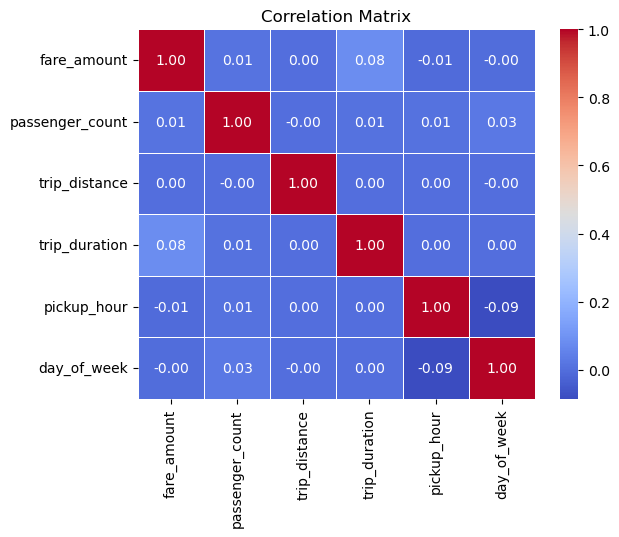

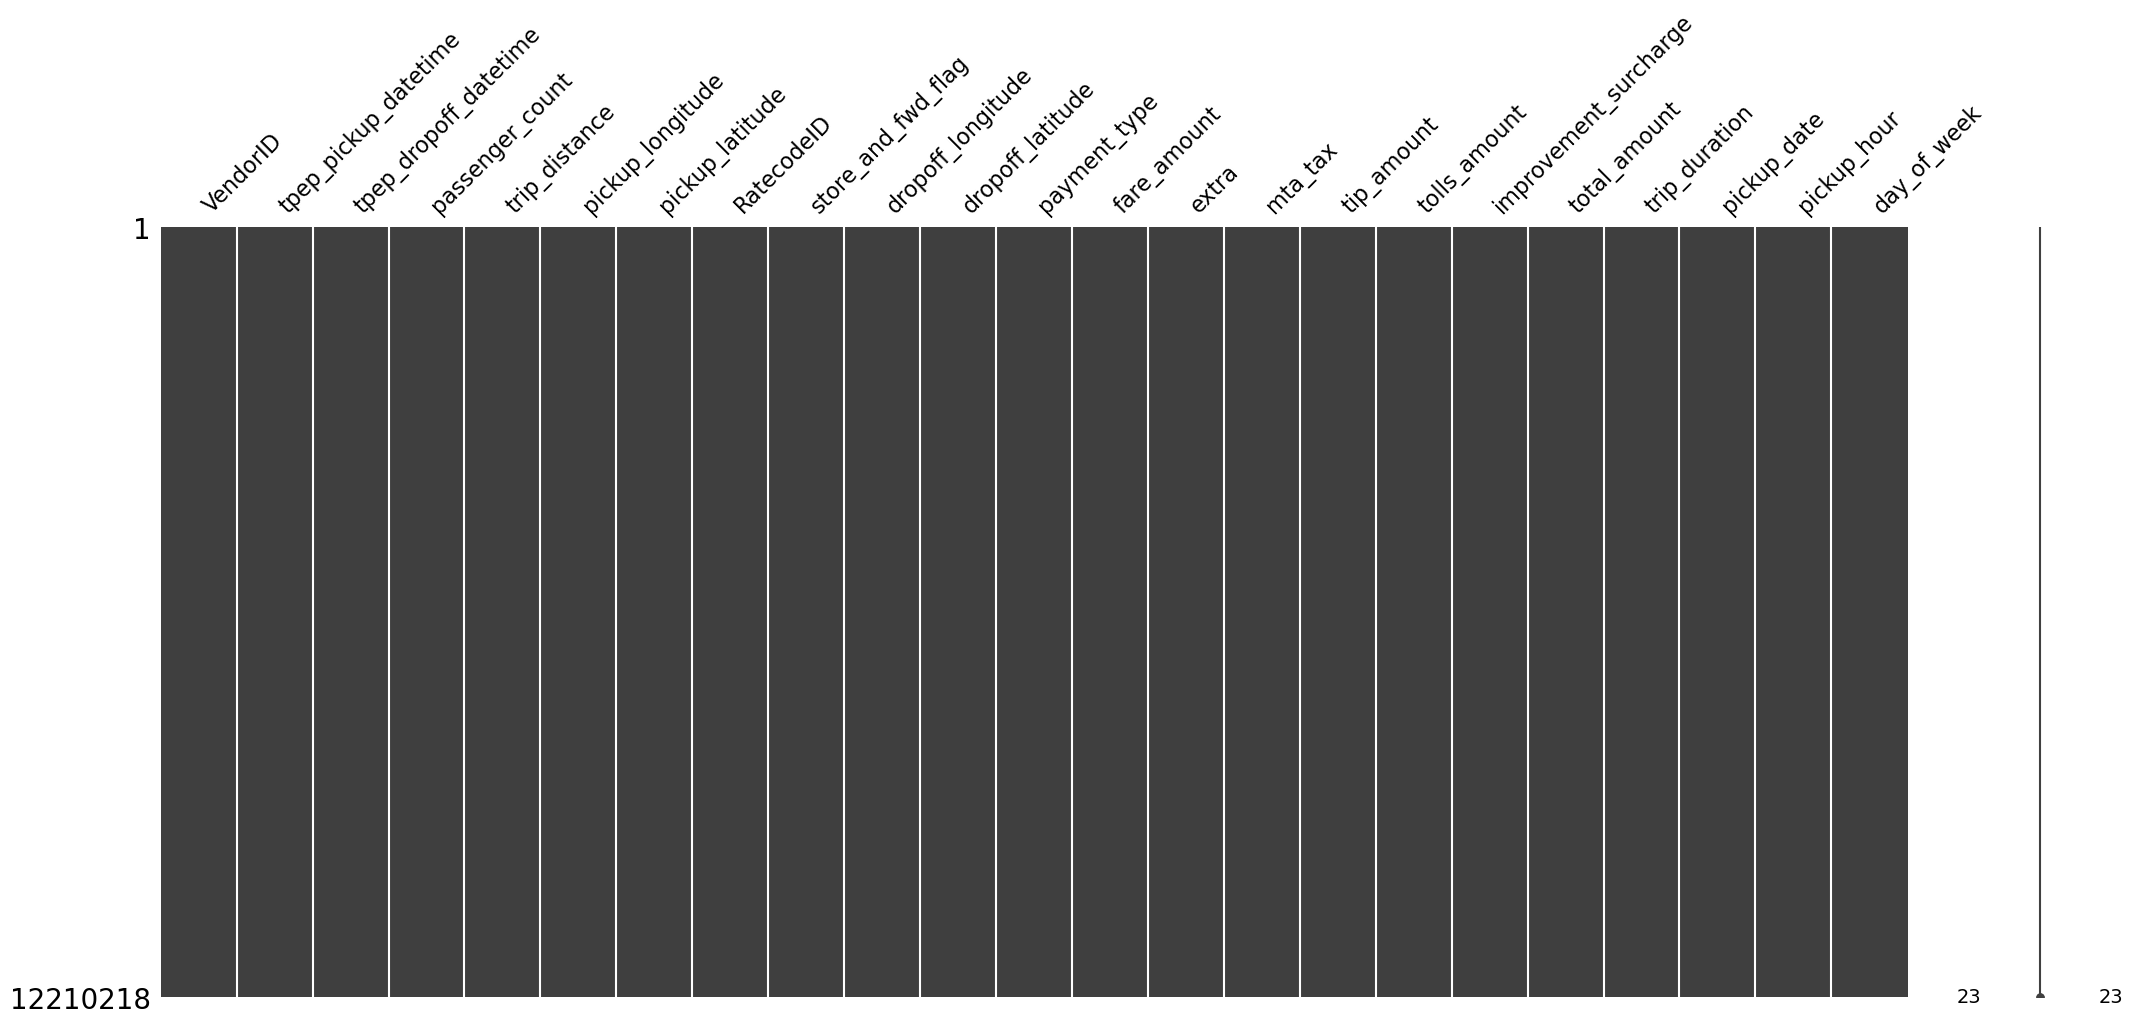

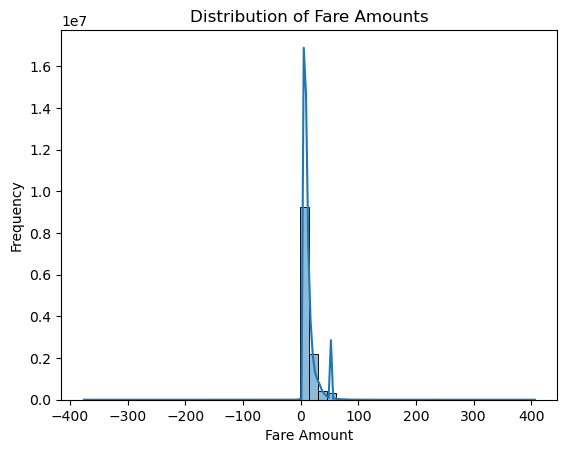

In [11]:
# Compute summary statistics
summary_stats = ddf.describe().compute()
summary_stats

# Correlation matrix to analyze relationships between numeric features
correlation_matrix = ddf[['fare_amount', 'passenger_count', 'trip_distance', 'trip_duration', 'pickup_hour', 'day_of_week']].compute().corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Visualize missing data patterns
msno.matrix(ddf.compute())
plt.show()

# Distribution of fare_amount
sns.histplot(ddf['fare_amount'].compute(), kde=True, bins=50)
plt.title("Distribution of Fare Amounts")
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.show()

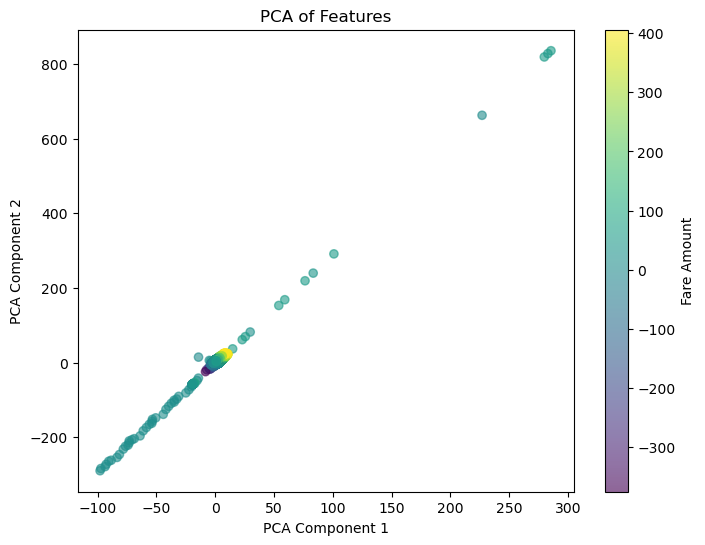

In [12]:
# Standardize the features using StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(ddf[['fare_amount', 'passenger_count', 'trip_distance', 'trip_duration', 'pickup_hour', 'day_of_week']].compute())

# Apply PCA for dimensionality reduction (reduce it to 2 components for visualization)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

# Plot the PCA components
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=ddf['fare_amount'].compute(), cmap='viridis', alpha=0.6)
plt.colorbar(label='Fare Amount')
plt.title("PCA of Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

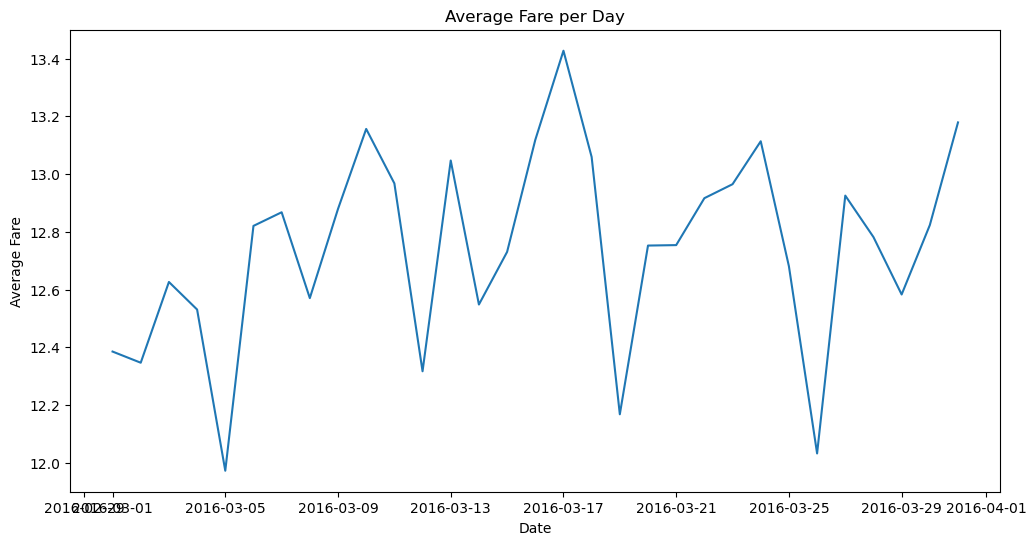

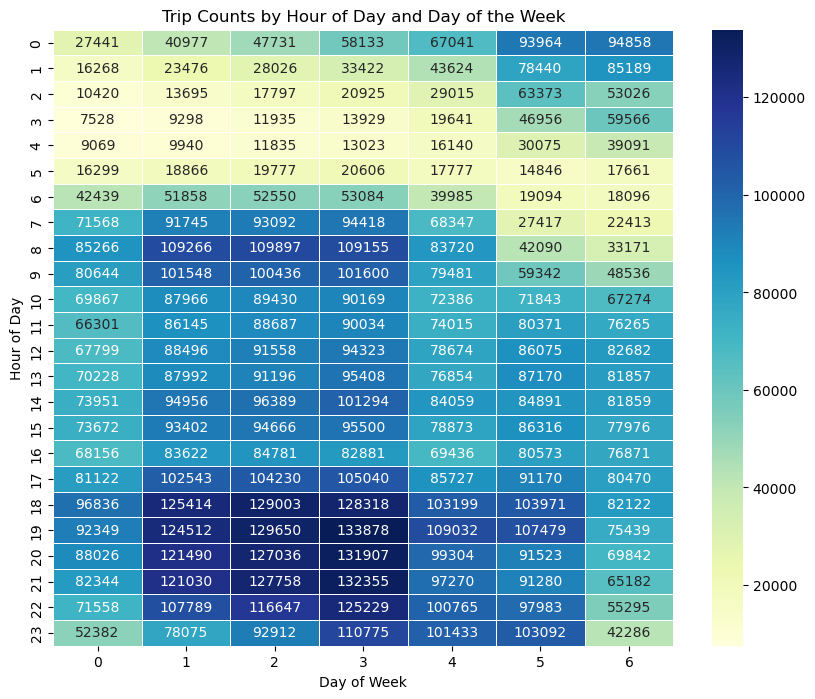

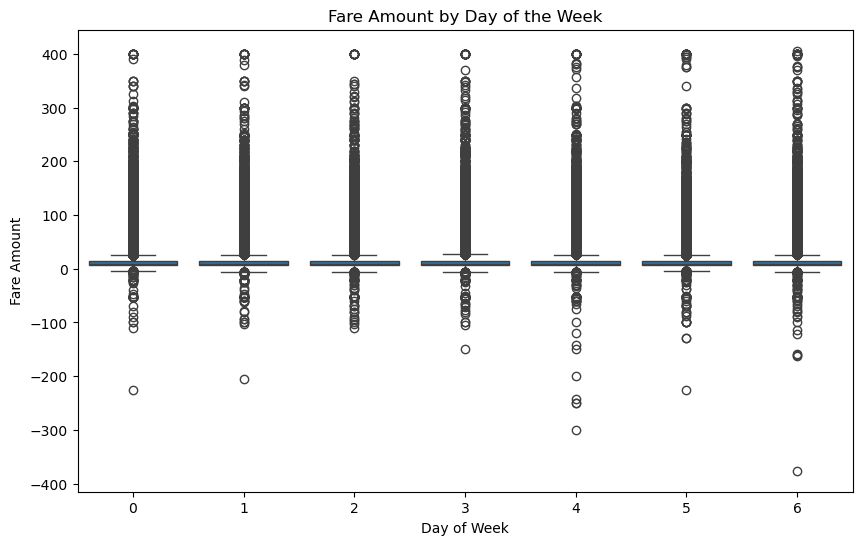

In [13]:
# Time series plot of average fare by day
avg_fare_per_day = ddf.groupby('pickup_date').agg({'fare_amount': 'mean'}).compute()
plt.figure(figsize=(12, 6))
avg_fare_per_day['fare_amount'].plot(kind='line', title="Average Fare per Day")
plt.xlabel('Date')
plt.ylabel('Average Fare')
plt.show()

# Heatmap of trips by hour of day and day of the week
trip_counts_by_time = ddf.groupby(['pickup_hour', 'day_of_week']).size().compute().unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(trip_counts_by_time, cmap="YlGnBu", annot=True, fmt="d", linewidths=0.5)
plt.title("Trip Counts by Hour of Day and Day of the Week")
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.show()

# Boxplot of fare amount by day of the week
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='fare_amount', data=ddf.compute())
plt.title("Fare Amount by Day of the Week")
plt.xlabel('Day of Week')
plt.ylabel('Fare Amount')
plt.show()

In [14]:
# Save the processed data to a CSV file
processed_data_path = "processed_yellow_taxi_data.csv"
ddf.compute().to_csv(processed_data_path, index=False)

# Save the PCA components for future analysis or use
pca_df = pd.DataFrame(pca_components, columns=["PCA1", "PCA2"])
pca_df.to_csv("pca_components.csv", index=False)